<a href="https://colab.research.google.com/github/Termote/Deep_learning_for_optical_imaging/blob/main/Final_project_DefeatChatGPT_Camera1_zahra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Data

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Activation
from keras.layers import Conv2D, MaxPooling2D,TimeDistributed, Concatenate, Conv3D, MaxPooling3D, BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import cv2
import os
import gdown

In [3]:
# Download the data training folder
url = "https://drive.google.com/drive/folders/1M2xGjlMKTfD0cRlI6eS2nEeKe0KKsfMb"
gdown.download_folder(url, quiet=True, use_cookies=False)



['/content/Training Data/common_time.npy',
 '/content/Training Data/ground_truth.npy',
 '/content/Training Data/labels.npy',
 '/content/Training Data/meteo_data.csv',
 '/content/Training Data/X1.npy',
 '/content/Training Data/X2.npy']

In [4]:
import pandas as pd
import os

# File paths and corresponding column names
file_columns = [('/content/Training Data/common_time.npy', 'common_time'),
                ('/content/Training Data/ground_truth.npy', 'ground_truth'),
                ('/content/Training Data/labels.npy', 'labels'),
                ('/content/Training Data/meteo_data.csv', 'meteo_data')]
# Create an empty DataFrame
combined_df = pd.DataFrame()

# Load and add data to the DataFrame
for file_path, column_name in file_columns:
    if file_path.endswith('.npy'):
        data = np.load(file_path, allow_pickle=True)
        df = pd.DataFrame(data, columns=[column_name])
        combined_df = pd.concat([combined_df, df], axis=1)
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
        df.columns = [f"{column_name}_{col}" for col in df.columns]
        combined_df = pd.concat([combined_df, df], axis=1)

# Display the combined DataFrame
print("Combined DataFrame:")

#remove one of the date columns
combined_df = combined_df.drop('meteo_data_time', axis=1)
combined_df.head(5)

Combined DataFrame:


,common_time,ground_truth,labels,meteo_data_Air_temp,meteo_data_Wind_speed,meteo_data_Wind_dir
0,2021-12-06 08:50:00,21.0,132.0,1.6,1.0,324
1,2021-12-06 09:10:00,34.0,126.0,1.8,1.2,331
2,2021-12-06 09:20:00,52.0,136.0,1.7,1.7,329
3,2021-12-06 09:30:00,70.0,143.0,1.8,1.3,325
4,2021-12-06 09:50:00,82.0,134.0,1.9,1.0,326


In [5]:
# Load images
x1 = np.load('/content/Training Data/X1.npy')
x2 = np.load('/content/Training Data/X2.npy')


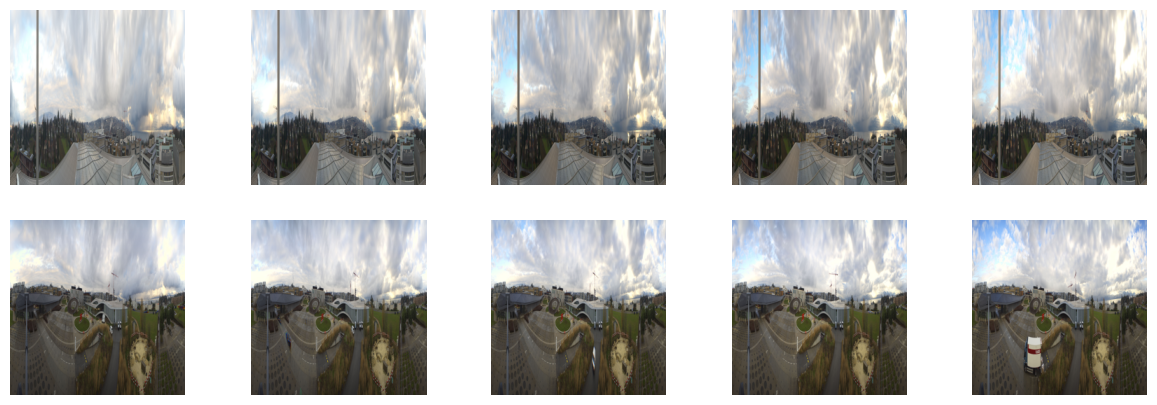

x1 shape:  (10000, 250, 250, 3)
x2 shape:  (10000, 250, 250, 3)


In [6]:
# Create a subplot with two rows and five columns
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

# Display images in the subplot
for i in range(5):
    axes[0, i].imshow(x1[i])
    axes[0, i].axis('off')
    axes[1, i].imshow(x2[i])
    axes[1, i].axis('off')

plt.show()

print("x1 shape: ", x1.shape)
print("x2 shape: ", x2.shape)

In [7]:
# Resizing the images to new dimensions

# take only every two images and combined_df
x1 = x1[::2]
x2 = x2[::2]
combined_df = combined_df.iloc[::2]


new_dim = 100
image_crop_percent = 0 # (top, bottom, left, right)
side_dim_scaled = (new_dim, int(new_dim * (1 - image_crop_percent)))

x1_resized = np.array([cv2.resize(img, (new_dim, new_dim)) for img in x1])
del x1
# crop the images
x1_resized = x1_resized[:, 0:int(x1_resized.shape[1]*(1-image_crop_percent))]

x2_resized = np.array([cv2.resize(img, (new_dim, new_dim)) for img in x2])
del x2
# crop the images
x2_resized = x2_resized[:, 0:int(x2_resized.shape[1]*(1-image_crop_percent))]

# normalize the images

x1_resized = x1_resized / 255.0
x2_resized = x2_resized / 255.0

new_dim = (x1_resized.shape[1], x1_resized.shape[2])

x1_resized shape:  (5000, 100, 100, 3)
x2_resized shape:  (5000, 100, 100, 3)


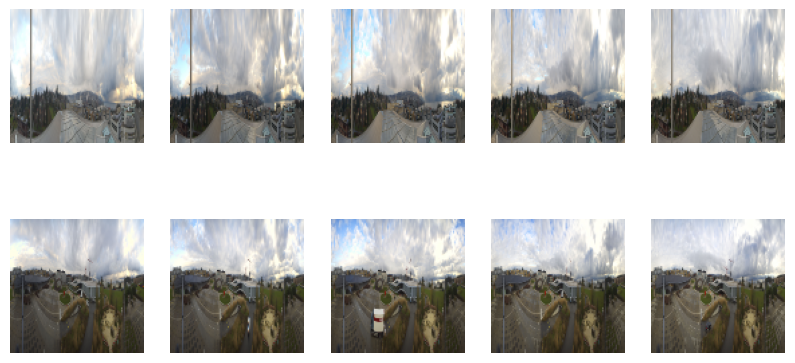

In [8]:
print("x1_resized shape: ", x1_resized.shape)
print("x2_resized shape: ", x2_resized.shape)

# Create a subplot with two rows and five columns
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# Display images in the subplot
for i in range(5):
    axes[0, i].imshow(x1_resized[i])
    axes[0, i].axis('off')
    axes[1, i].imshow(x2_resized[i])
    axes[1, i].axis('off')

plt.show()

In [9]:
# #Split data - Conventional way

def split_train_test(data, train_test_ratio):
    train_size = int(len(data) * train_test_ratio)
    return data[:train_size], data[train_size:]

def create_train_test(data_1, data_2, info_ds, train_test_ratio):

    wind_speed = info_ds['meteo_data_Wind_speed']
    wind_speed = np.array(wind_speed)

    labels = info_ds['labels']
    labels = np.array(labels)

    train_x1, test_x1 = split_train_test(data_1, train_test_ratio)
    train_x2, test_x2 = split_train_test(data_2, train_test_ratio)
    train_wind, test_wind = split_train_test(wind_speed, train_test_ratio)

    y_train, y_test = split_train_test(labels, train_test_ratio)

#     X_images_train = np.stack((train_x1, train_x2), 1)
#     X_images_test = np.stack((test_x1, test_x2), 1)

# #Shuffle the data for training
#     idx = np.random.permutation(len(X_images_train))

    # X_images_train, X_wind_train, y_train = X_images_train[idx], train_wind[idx], y_train[idx]

    # return X_images_train, X_wind_train, X_images_test, test_wind, y_train, y_test
    return train_x1, test_x1, y_train, y_test

# Split data set
train_test_ratio = 0.9

# X_images_train, X_wind_train, X_images_test, X_test_wind, y_train, y_test = create_train_test(x1_resized, x2_resized, combined_df, train_test_ratio)


train_x1, test_x1, y_train, y_test = create_train_test(x1_resized, x2_resized, combined_df, train_test_ratio)



print("x1 train shape:", train_x1.shape)
# print("x2 train shape:", train_x2.shape)

# print("X_wind_train shape:", train_wind.shape)
print("x1 test  shape:", test_x1.shape)
# print("x2 test shape:", test_x2.shape)

# print("X_test_wind shape:", test_wind.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# print("X_images_train shape:", X_images_train.shape)
# print("X_wind_train shape:", X_wind_train.shape)
# print("X_images_test shape:", X_images_test.shape)
# print("X_test_wind shape:", X_test_wind.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)

#del x1
#del x2

x1 train shape: (4500, 100, 100, 3)
x1 test  shape: (500, 100, 100, 3)
y_train shape: (4500,)
y_test shape: (500,)


#ChatGPT model


#Train by Camera 1

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Dense, Flatten, concatenate
import numpy as np

Train with Camera 1 and 2 together

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense

new_dim = (100, 100)
channels = 3

input_x1 = tf.keras.layers.Input(shape=(new_dim[0], new_dim[1], channels))
print(input_x1.shape)

# CNN Block 1
first_input = Conv2D(8, kernel_size=3, activation='relu')(input_x1)
first_input = MaxPooling2D(pool_size=2)(first_input)
first_input = Conv2D(8, kernel_size=3, activation='relu')(first_input)
first_input = MaxPooling2D(pool_size=2)(first_input)

# CNN Block 2
first_input = Conv2D(16, kernel_size=3, activation='relu')(first_input)
first_input = MaxPooling2D(pool_size=2)(first_input)
first_input = Conv2D(16, kernel_size=3, activation='relu')(first_input)
first_input = MaxPooling2D(pool_size=2)(first_input)

# Flattening
flt = Flatten()(first_input)
flt = tf.expand_dims(flt, axis=1)  # Reshape to add a time step dimension
print(flt.shape)

# LSTM
lstm1 = LSTM(32, activation='relu')(flt)

# Output
dense1 = Dense(1, activation='relu')(lstm1)

# Create the model
model = tf.keras.models.Model(inputs=input_x1, outputs=dense1)


(None, 100, 100, 3)
(None, 1, 256)


Graphical schematic of the compiled network

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_39 (Conv2D)          (None, 98, 98, 8)         224       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 49, 49, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 47, 47, 8)         584       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 23, 23, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_41 (Co

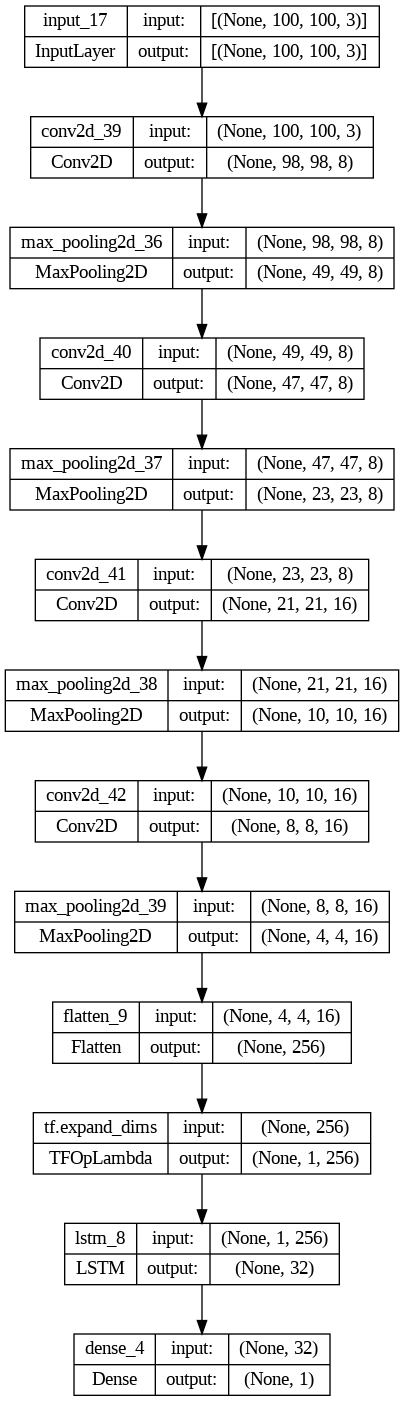

In [32]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# compile the model and use mse as loss function
model.compile(optimizer='adam', loss='mean_squared_error')

print('Graphical schematic of the compiled network')
print()
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(filename='model.png')

In [33]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_list = []

def reset_model(model):
    model_copy = tf.keras.models.clone_model(model)
    model_copy.set_weights(model.get_weights())
    return model_copy

for i in range(5):
    print('Training iteration:', i+1)
    print()

    model_copy = reset_model(model)
    model_copy.compile(optimizer='adam', loss='mean_squared_error') # default lr = 0.001

    history = model_copy.fit(train_x1, y_train, shuffle=True, epochs=50, batch_size=128, verbose=2, validation_split=0.1)
    print()
    print('Training RMSE:', np.sqrt(history.history['loss'][-1]))
    print('Validation RMSE:', np.sqrt(history.history['val_loss'][-1]))

    y_pred = model_copy.predict(test_x1)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print('Test RMSE:', rmse)
    print()

    rmse_list.append(rmse)
    if i != 4:
        del model_copy
        del history

# Calculate the average test RMSE after 5 training iterations
average_rmse = np.mean(rmse_list)
std_dev_rmse = np.std(rmse_list)

print('Average test RMSE:', average_rmse)
print('Standard deviation of test RMSE:', std_dev_rmse)


Training iteration: 1

Epoch 1/50
32/32 - 15s - loss: 166084.3906 - val_loss: 66613.1016 - 15s/epoch - 457ms/step
Epoch 2/50
32/32 - 1s - loss: 82149.1719 - val_loss: 63532.8750 - 528ms/epoch - 17ms/step
Epoch 3/50
32/32 - 1s - loss: 76314.9062 - val_loss: 62423.6094 - 536ms/epoch - 17ms/step
Epoch 4/50
32/32 - 1s - loss: 74476.2734 - val_loss: 57266.2969 - 533ms/epoch - 17ms/step
Epoch 5/50
32/32 - 1s - loss: 72245.4297 - val_loss: 54885.4844 - 538ms/epoch - 17ms/step
Epoch 6/50
32/32 - 1s - loss: 69170.6250 - val_loss: 53265.1680 - 531ms/epoch - 17ms/step
Epoch 7/50
32/32 - 1s - loss: 63950.0742 - val_loss: 47972.8203 - 529ms/epoch - 17ms/step
Epoch 8/50
32/32 - 1s - loss: 53822.3281 - val_loss: 35105.9727 - 534ms/epoch - 17ms/step
Epoch 9/50
32/32 - 1s - loss: 48370.9805 - val_loss: 34756.5859 - 526ms/epoch - 16ms/step
Epoch 10/50
32/32 - 1s - loss: 45806.3320 - val_loss: 33357.6797 - 520ms/epoch - 16ms/step
Epoch 11/50
32/32 - 1s - loss: 44276.1836 - val_loss: 33164.2344 - 520ms/ep

Test RMSE: 165.80779904392514

Training iteration: 2

Epoch 1/50
32/32 - 4s - loss: 166381.8906 - val_loss: 66059.5469 - 4s/epoch - 136ms/step
Epoch 2/50
32/32 - 1s - loss: 83418.7734 - val_loss: 66622.4844 - 578ms/epoch - 18ms/step
Epoch 3/50
32/32 - 1s - loss: 76791.1484 - val_loss: 60740.1875 - 548ms/epoch - 17ms/step
Epoch 4/50
32/32 - 1s - loss: 75005.9844 - val_loss: 55426.3945 - 537ms/epoch - 17ms/step
Epoch 5/50
32/32 - 1s - loss: 73077.4219 - val_loss: 56773.7383 - 509ms/epoch - 16ms/step
Epoch 6/50
32/32 - 1s - loss: 70843.4062 - val_loss: 54002.6523 - 509ms/epoch - 16ms/step
Epoch 7/50
32/32 - 1s - loss: 67104.7500 - val_loss: 52143.2969 - 501ms/epoch - 16ms/step
Epoch 8/50
32/32 - 1s - loss: 59834.0000 - val_loss: 41567.3672 - 506ms/epoch - 16ms/step
Epoch 9/50
32/32 - 1s - loss: 50226.7656 - val_loss: 34754.6523 - 510ms/epoch - 16ms/step
Epoch 10/50
32/32 - 1s - loss: 47812.2500 - val_loss: 38320.7500 - 536ms/epoch - 17ms/step
Epoch 11/50
32/32 - 1s - loss: 45587.7852 - va

Test RMSE: 166.04890282807247

Training iteration: 3

Epoch 1/50
32/32 - 4s - loss: 165393.3750 - val_loss: 64563.7930 - 4s/epoch - 119ms/step
Epoch 2/50
32/32 - 1s - loss: 82415.9531 - val_loss: 69199.2812 - 526ms/epoch - 16ms/step
Epoch 3/50
32/32 - 1s - loss: 76634.0703 - val_loss: 62640.6328 - 532ms/epoch - 17ms/step
Epoch 4/50
32/32 - 1s - loss: 75186.9609 - val_loss: 60496.9414 - 516ms/epoch - 16ms/step
Epoch 5/50
32/32 - 1s - loss: 72787.4844 - val_loss: 57632.2148 - 561ms/epoch - 18ms/step
Epoch 6/50
32/32 - 1s - loss: 70213.0469 - val_loss: 49547.4453 - 540ms/epoch - 17ms/step
Epoch 7/50
32/32 - 1s - loss: 66246.1797 - val_loss: 49157.1016 - 549ms/epoch - 17ms/step
Epoch 8/50
32/32 - 1s - loss: 57565.1406 - val_loss: 37406.5898 - 541ms/epoch - 17ms/step
Epoch 9/50
32/32 - 1s - loss: 48756.1914 - val_loss: 37164.9922 - 501ms/epoch - 16ms/step
Epoch 10/50
32/32 - 1s - loss: 46894.5703 - val_loss: 33167.3398 - 518ms/epoch - 16ms/step
Epoch 11/50
32/32 - 1s - loss: 44052.7734 - va

Test RMSE: 145.63233013948863

Training iteration: 4

Epoch 1/50
32/32 - 4s - loss: 165735.2500 - val_loss: 64291.2031 - 4s/epoch - 121ms/step
Epoch 2/50
32/32 - 1s - loss: 83170.5078 - val_loss: 61158.1562 - 522ms/epoch - 16ms/step
Epoch 3/50
32/32 - 1s - loss: 76469.8594 - val_loss: 58062.1484 - 525ms/epoch - 16ms/step
Epoch 4/50
32/32 - 1s - loss: 75106.6328 - val_loss: 61898.3633 - 516ms/epoch - 16ms/step
Epoch 5/50
32/32 - 1s - loss: 73026.0859 - val_loss: 55553.7734 - 512ms/epoch - 16ms/step
Epoch 6/50
32/32 - 1s - loss: 70594.9688 - val_loss: 51292.8789 - 513ms/epoch - 16ms/step
Epoch 7/50
32/32 - 1s - loss: 66896.3203 - val_loss: 47614.0586 - 525ms/epoch - 16ms/step
Epoch 8/50
32/32 - 1s - loss: 59766.2188 - val_loss: 38623.1641 - 546ms/epoch - 17ms/step
Epoch 9/50
32/32 - 1s - loss: 50664.1523 - val_loss: 34458.6680 - 523ms/epoch - 16ms/step
Epoch 10/50
32/32 - 1s - loss: 46957.1016 - val_loss: 33513.1992 - 539ms/epoch - 17ms/step
Epoch 11/50
32/32 - 1s - loss: 44987.3711 - va

Test RMSE: 153.0387567413556

Training iteration: 5

Epoch 1/50
32/32 - 4s - loss: 166186.8125 - val_loss: 66571.3281 - 4s/epoch - 123ms/step
Epoch 2/50
32/32 - 1s - loss: 82418.3984 - val_loss: 64107.8320 - 505ms/epoch - 16ms/step
Epoch 3/50
32/32 - 1s - loss: 69276.9609 - val_loss: 44473.8281 - 523ms/epoch - 16ms/step
Epoch 4/50
32/32 - 1s - loss: 54516.3008 - val_loss: 62994.7656 - 508ms/epoch - 16ms/step
Epoch 5/50
32/32 - 1s - loss: 50620.8906 - val_loss: 33475.4297 - 533ms/epoch - 17ms/step
Epoch 6/50
32/32 - 1s - loss: 47432.1875 - val_loss: 34877.4492 - 512ms/epoch - 16ms/step
Epoch 7/50
32/32 - 1s - loss: 43706.1562 - val_loss: 39252.9023 - 518ms/epoch - 16ms/step
Epoch 8/50
32/32 - 1s - loss: 40734.0781 - val_loss: 39637.2773 - 519ms/epoch - 16ms/step
Epoch 9/50
32/32 - 1s - loss: 39172.7656 - val_loss: 31873.3184 - 527ms/epoch - 16ms/step
Epoch 10/50
32/32 - 1s - loss: 37710.0195 - val_loss: 31619.9961 - 517ms/epoch - 16ms/step
Epoch 11/50
32/32 - 1s - loss: 37873.0430 - val

In [ ]:
# Plot the training and validation loss of the last model

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.yscale('log')
plt.show()

250/250 [==============================] - 1s 3ms/step
(8000, 1)
(8000,)
RMSE: 236.08134521748477


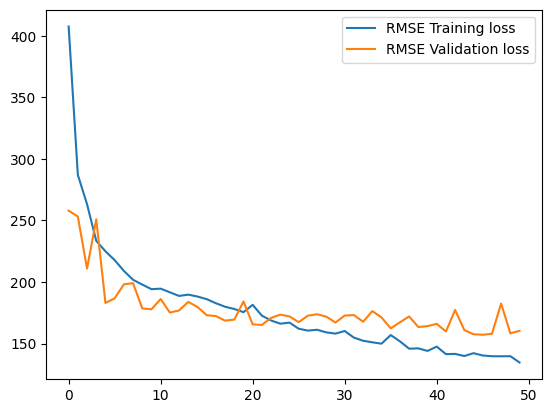

In [34]:
# Plot the RMSE loss of the last model

plt.plot(np.sqrt(history.history['loss']), label='RMSE Training loss')
plt.plot(np.sqrt(history.history['val_loss']), label='RMSE Validation loss')
plt.legend()
plt.show()

In [36]:
# Evaluate the model

from sklearn.metrics import mean_squared_error

y_pred = model_copy.predict(test_x1)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE:", rmse)

16/16 [==============================] - 0s 3ms/step
RMSE: 157.36466771102877
